# Matrix Multiplication

In [1]:
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline

import seaborn as sns; sns.set()
plt.rcParams["figure.figsize"] = (16, 8)

### Machine specification

- Processor: CPUIntel Core i7 (7th Gen) 7700HQ / 2.8 GHz
- Max Turbo Speed: 3.8 GHz
- Number of Cores: 4
- Number of threads: 8
- L3 Cache: 6 MB
- L2 Cache: 1 MB
- L1 Cache: 256 KB

Windows10; code compiled in MS Visual Studio 2017; compiler optimisation disabled. 

### Benchmarks 

The following benchmarks were recorded for each of the six possible permutations of I J K loop order.

    for (int i = 0; i < N; i++) {
        for (int j = 0; j < N; j++) {
            for (int k = 0; k < N; k++) {
                C[i][j] += A[i][k] * B[k][j];
            }
        }
    }

In [2]:
data = {}

# I outer loop
data['I J K'] = [11013, 11066, 10542, 11069, 10937, 11089]
data['I K J'] = [3860, 3775, 3779, 3806, 3799, 3760]

# K outer loop
data['K J I'] = [10908, 11360, 11620, 12615, 11240, 11704]
data['K I J'] = [4014, 4023, 3964, 3889, 3907, 4073]

# J outer loop
data['J I K'] = [7394, 7354, 7363, 7415, 7213, 7013]
data['J K I'] = [15689, 15514, 15519, 15601, 15478, 15406]

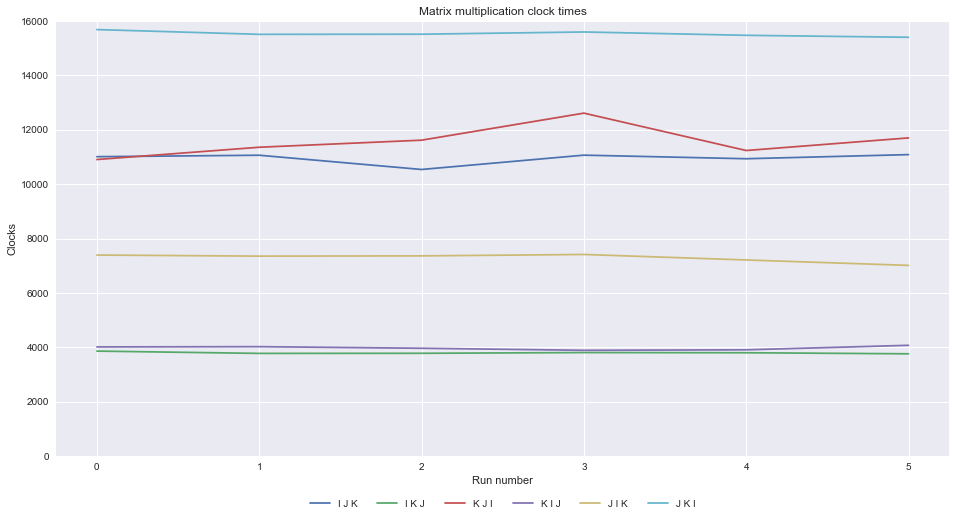

In [3]:
def plot_performance_stats(data):
    run = np.arange(6)
    fig, ax = plt.subplots()
    
    for label, run_times in data.items():
        plt.plot(run, run_times, label=label)
   
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08), ncol=7) 
    
    plt.xlabel('Run number')
    plt.ylabel('Clocks')
    plt.title('Matrix multiplication clock times')
    ax.set_ylim(0, 16000)
    
plot_performance_stats(data)

The fastest loop order (on my machine) was **I K J**

### Inner loop partial unrolling

	for (int i = 0; i < N; i++) {
		for (int j = 0; j < N; j++) {
			for (int k = 0; k < N; k += 4) {
				double * aik = &A[i][k];
				C[i][j] += aik[0] * B[k][j]
						+ aik[1] * B[k + 1][j]
						+ aik[2] * B[k + 2][j]
						+ aik[3] * B[k + 3][j];
			}
		}
	}


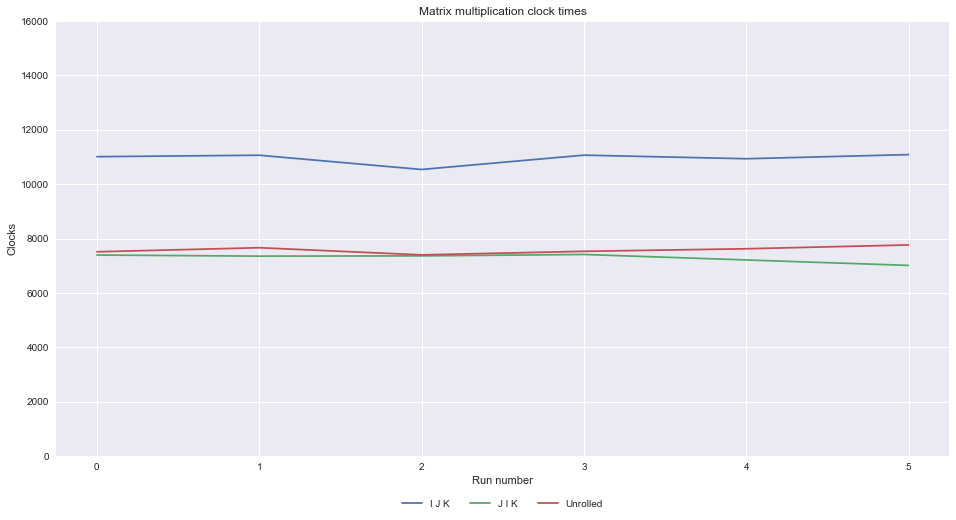

In [4]:
data = {}
data['I J K'] = [11013, 11066, 10542, 11069, 10937, 11089]
data['J I K'] = [7394, 7354, 7363, 7415, 7213, 7013]
data['Unrolled'] =  [7514, 7663, 7400, 7530, 7625, 7765]

plot_performance_stats(data)

Unrolling the inner loop of **I J K** delivers performance on a par with **J I K**

## Block tiling

The following results plot peformance for this arrangement of block tiling as a function of block size.  All possible permitations of **I J K** order were tried for both inner and outer loops; this was always the fastest.

(The array dimensions were updated to be statically defined to avoid seg faults occuring at particular block sizes.)

	for (int i = 0; i < N; i += block_size) {
		for (int k = 0; k < N; k += block_size) {
			for (int j = 0; j < N; j += block_size) {

				for (int ii = i; ii < (i + block_size); ii++) {
					for (int kk = k; kk < (k + block_size); kk++) {
						for (int jj = j; jj < (j + block_size); jj++) {
							C[ii][jj] += A[ii][kk] * B[kk][jj];

						}
					}
				}
			}
		}
	}


(0, 25000)

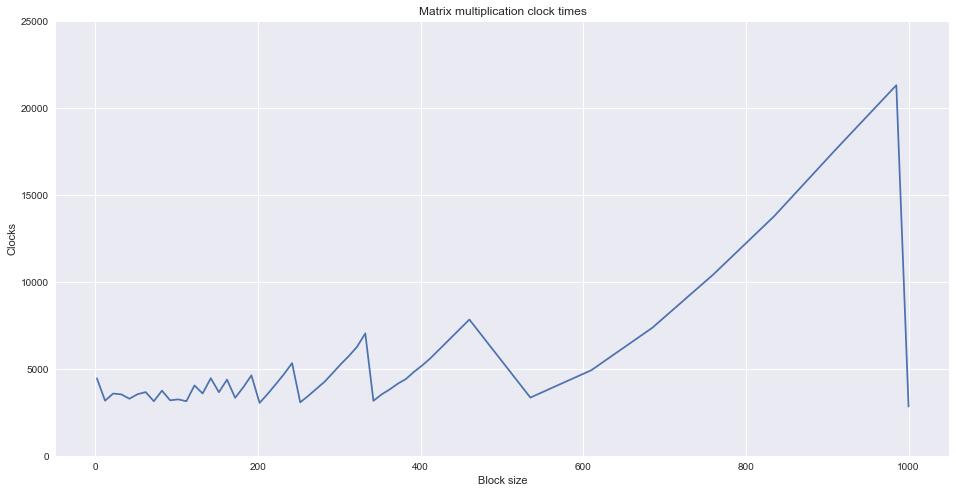

In [5]:
block_size = np.array([2,12,22,32,42,52,62,72,82,92,102,112,122,132,142,152,162,172,182,192,202,212,222,232,242,
                       252,262,272,282,292,302,312,322,332,342,352,362,372,382,392,402,412,460,535,610,685,760,
                       835,910,985,1000])
                      
clocks = np.array([4452,3170,3579,3532,3280,3541,3661,3136,3745,3191,3243,3138,4044,3582,4460,3656,4377,3333,
                   3940,4624,3040,3559,4118,4693,5329,3076,3449,3856,4260,4760,5274,5742,6275,7038,3159,3526,
                   3817,4145,4415,4831,5195,5604,7832,3347,4922,7362,10426,13785,17584,21305,2833])
                      
fig, ax = plt.subplots()

plt.plot(block_size, clocks)
                      
plt.xlabel('Block size')
plt.ylabel('Clocks')
plt.title('Matrix multiplication clock times')
ax.set_ylim(0, 25000)

Minimum clocks seem to occur where block size is a factor of 1,000 (the leading dimension of the arrays being multiplied) and the asbolute fastest time was for block size 1,000 which is the only case where elapsed time dipped under 3 seconds (equivelently 3,000 clocks).

## Additional layer of tiling

The following was used to obtain data for clocks as a function of b (outter tile) and c (inner tile).  

Compiler set to custom optimisation / max performance.

Empirically, perfomance seemed to peak where b was a factor of 1,000; c was a factor of b; c less than or equal to srqr(b); both b and c factors of 2 (potentiallt useful to cut down the set of permutations if trying to find a global optimimum through brute force).

	// Outer loop, optimised for RAM access.
	for (int i = 0; i < N; i += b) {
		for (int j = 0; j < N; j += b) {
			for (int k = 0; k < N; k += b) {

				// CPU Cache optimisation
				for (int ii = i; ii < (i + b); ii += c) {
					for (int jj = j; jj < (j + b); jj += c) {
						for (int kk = k; kk < (k + b); kk += c) {

							// CPU Register optimisation
							for (int kkk = kk; kkk < (kk + c); kkk++) {
								for (int jjj = jj; jjj < (jj + c); jjj++) {
									for (int iii = ii; iii < (ii + c); iii++) {
										C[iii][jjj] += A[iii][kkk] * B[kkk][jjj];
									}
								}
							}

						}
					}
				}

			}
		}
	


In order to generate a reasonably smooth and dense plot, the range of b and c size permutations was kept small and in the region of the globally optimal solution.

In [6]:
b = np.array([8,8,8,8,8,8,8,10,10,10,10,10,10,10,12,12,12,12,12,12,12,14,14,
              14,14,14,14,14,16,16,16,16,16,16,16,18,18,18,18,18,18,18,20,20,
              20,20,20,20,20,22,22,22,22,22,22,22,24,24,24,24,24,24,24,26,26,
              26,26,26,26,26,28,28,28,28,28,28,28,30,30,30,30,30,30,30,32,32,
              32,32,32,32,32])

c = np.array([4,6,8,10,12,14,16,4,6,8,10,12,14,16,4,6,8,10,12,14,16,4,6,8,10,
              12,14,16,4,6,8,10,12,14,16,4,6,8,10,12,14,16,4,6,8,10,12,14,16,
              4,6,8,10,12,14,16,4,6,8,10,12,14,16,4,6,8,10,12,14,16,4,6,8,10,
              12,14,16,4,6,8,10,12,14,16,4,6,8,10,12,14,16])

clocks = np.array([3753,11225,3158,6342,10148,18573,25001,6130,5536,13265,3327,
                   5576,9521,12806,3878,3522,7876,15065,3309,5382,7627,5710,7271,
                   4689,9559,16277,3552,4846,3709,4848,3250,6423,10668,18690,3234,
                   5170,3311,7358,4538,7627,13233,17211,3632,5411,5539,3057,5459,
                   9336,11944,4668,4219,4043,8407,4246,7037,9541,3528,3400,3265,6413,
                   3175,5571,7512,4669,4973,5865,5128,8198,4192,5815,3726,4161,4869,
                   4071,6845,3304,4713,4556,3303,4107,3227,5575,9637,4010,3921,5048,
                   3234,6598,4829,7844,3343])

In [7]:
unique_b = np.unique(b)
unique_c = np.unique(c)

In [8]:
X, Y = np.meshgrid(unique_b, unique_c)

In [9]:
keys = ['{0}_{1}'.format(b, c) for b, c in zip(b, c)]
data_dict = dict(zip(keys, clocks))

zs = np.array([data_dict.get('{0}_{1}'.format(b, c), np.nan) for 
               b, c in zip(np.ravel(X), np.ravel(Y))])

Z = zs.reshape(X.shape)

In [10]:
X

array([[ 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32],
       [ 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32],
       [ 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32],
       [ 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32],
       [ 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32],
       [ 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32],
       [ 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32]])

In [11]:
Y

array([[ 4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4],
       [ 6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6],
       [ 8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8],
       [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
       [12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12],
       [14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14],
       [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16]])

In [12]:
Z

array([[ 3753,  6130,  3878,  5710,  3709,  5170,  3632,  4668,  3528,
         4669,  3726,  4556,  3921],
       [11225,  5536,  3522,  7271,  4848,  3311,  5411,  4219,  3400,
         4973,  4161,  3303,  5048],
       [ 3158, 13265,  7876,  4689,  3250,  7358,  5539,  4043,  3265,
         5865,  4869,  4107,  3234],
       [ 6342,  3327, 15065,  9559,  6423,  4538,  3057,  8407,  6413,
         5128,  4071,  3227,  6598],
       [10148,  5576,  3309, 16277, 10668,  7627,  5459,  4246,  3175,
         8198,  6845,  5575,  4829],
       [18573,  9521,  5382,  3552, 18690, 13233,  9336,  7037,  5571,
         4192,  3304,  9637,  7844],
       [25001, 12806,  7627,  4846,  3234, 17211, 11944,  9541,  7512,
         5815,  4713,  4010,  3343]])

In [13]:
z_min = Z.ravel()[Z.argmin()]
x_min = X.ravel()[Z.argmin()]
y_min = Y.ravel()[Z.argmin()]

print('Minimum clocks {0} obtained with blocks size b:{1} and c:{2}'.format(z_min, x_min, y_min))

Minimum clocks 3057 obtained with blocks size b:20 and c:10


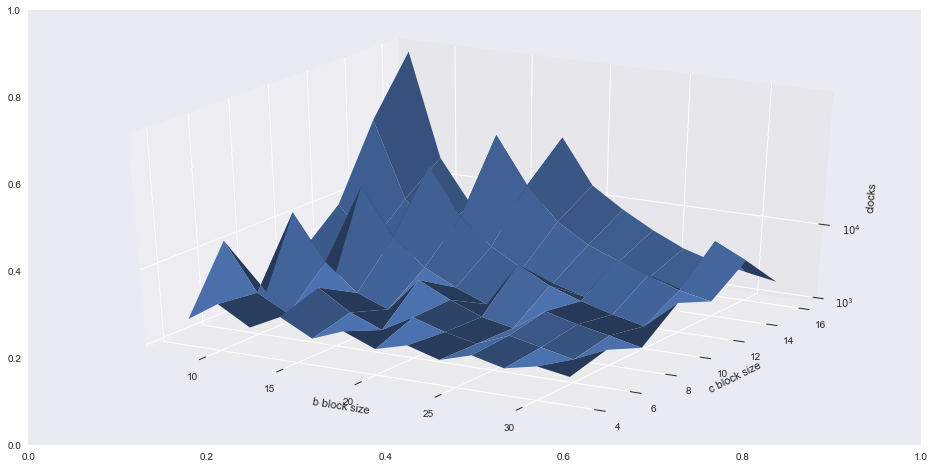

In [14]:
fig, ax = plt.subplots()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z)
ax.set_zscale('log')
ax.set_zlim(1e3)
ax.set_xlabel('b block size')
ax.set_ylabel('c block size')
ax.set_zlabel('clocks')
